In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import itertools
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from torch.nn import functional as F
from collections import Counter
from nltk.tokenize import word_tokenize
import nltk
from sklearn.metrics import precision_score, recall_score, f1_score
import sklearn

In [3]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [4]:
train_df = pd.read_csv('drive/MyDrive/Sentiment Analysis/data/train.csv')
val_df = pd.read_csv('drive/MyDrive/Sentiment Analysis/data/val.csv')
test_df = pd.read_csv('drive/MyDrive/Sentiment Analysis/data/test.csv')

def tokenize(text):
    return word_tokenize(text.lower())

train_texts = train_df['text'].tolist()
train_labels = train_df['label'].tolist()

val_texts = val_df['text'].tolist()
val_labels = val_df['label'].tolist()

test_texts = test_df['text'].tolist()
test_labels = test_df['label'].tolist()

label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)
val_labels = label_encoder.transform(val_labels)
test_labels = label_encoder.transform(test_labels)

In [5]:
all_texts = train_texts + val_texts + test_texts
tokenized_texts = [tokenize(text) for text in all_texts]

word_counts = Counter([word for sentence in tokenized_texts for word in sentence])
vocab = {word: idx+2 for idx, (word, _) in enumerate(word_counts.most_common())}
vocab['<PAD>'] = 0  # Padding token
vocab['<UNK>'] = 1  # Unknown token

def text_to_sequence(text, vocab):
    return [vocab.get(word, vocab['<UNK>']) for word in tokenize(text)]

In [6]:
train_sequences = [text_to_sequence(text, vocab) for text in train_texts]
val_sequences = [text_to_sequence(text, vocab) for text in val_texts]
test_sequences = [text_to_sequence(text, vocab) for text in test_texts]

def pad_sequences(sequences, max_len=100):
    return [seq[:max_len] + [0] * (max_len - len(seq)) if len(seq) < max_len else seq[:max_len] for seq in sequences]

train_sequences = pad_sequences(train_sequences)
val_sequences = pad_sequences(val_sequences)
test_sequences = pad_sequences(test_sequences)

In [7]:
X_train = torch.tensor(train_sequences, dtype=torch.long)
y_train = torch.tensor(train_labels, dtype=torch.long)
X_val = torch.tensor(val_sequences, dtype=torch.long)
y_val = torch.tensor(val_labels, dtype=torch.long)
X_test = torch.tensor(test_sequences, dtype=torch.long)
y_test = torch.tensor(test_labels, dtype=torch.long)

train_data = TensorDataset(X_train, y_train)
val_data = TensorDataset(X_val, y_val)
test_data = TensorDataset(X_test, y_test)


In [8]:
train_data[0]

(tensor([15499,  2434,   583,    55,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]),
 tensor(1))

In [5]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size= 20000, embed_size=100, hidden_size=128, num_classes=2):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        lstm_out, (hn, cn) = self.lstm(x)
        hidden_state = hn[0]
        out = self.fc(hidden_state)
        return out

In [6]:
from torchsummary import summary

In [9]:
!pip install torchinfo

  Using cached torchinfo-1.8.0-py3-none-any.whl.metadata (21 kB)
Using cached torchinfo-1.8.0-py3-none-any.whl (23 kB)


In [11]:
from torchinfo import summary
model = LSTMModel(vocab_size=32186, embed_size=100, hidden_size=128, num_classes=2)
summary(model, input_size=(1, 100), dtypes=[torch.long])

Layer (type:depth-idx)                   Output Shape              Param #
LSTMModel                                [1, 2]                    --
├─Embedding: 1-1                         [1, 100, 100]             3,218,600
├─LSTM: 1-2                              [1, 100, 128]             117,760
├─Linear: 1-3                            [1, 2]                    258
Total params: 3,336,618
Trainable params: 3,336,618
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 14.99
Input size (MB): 0.00
Forward/backward pass size (MB): 0.18
Params size (MB): 13.35
Estimated Total Size (MB): 13.53

In [16]:
batch_sizes = [32, 64]
learning_rates = [1e-3, 1e-4]
optimizers = ['Adam', 'SGD']
results = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += (output.argmax(1) == target).sum().item()
    return total_loss / len(train_loader.dataset), correct / len(train_loader.dataset)


def evaluate(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            # Tính loss
            total_loss += criterion(output, target).item()

            # Lấy nhãn dự đoán
            preds = output.argmax(1)

            # Đếm số dự đoán đúng
            correct += (preds == target).sum().item()

            # Lưu nhãn thực tế và nhãn dự đoán
            true_labels.extend(target.cpu().numpy())
            predicted_labels.extend(preds.cpu().numpy())

    avg_loss = total_loss / len(test_loader.dataset)
    accuracy = correct / len(test_loader.dataset)

    return avg_loss, accuracy, true_labels, predicted_labels



Training LSTM with batch_size=32, lr=0.001, optimizer=Adam
Epoch 1/10 -> Train Loss: 0.0150, Train Acc: 0.8154, Val Loss: 0.0142, Val Acc: 0.8356
Epoch 2/10 -> Train Loss: 0.0127, Train Acc: 0.8325, Val Loss: 0.0110, Val Acc: 0.8696
Epoch 3/10 -> Train Loss: 0.0090, Train Acc: 0.8892, Val Loss: 0.0101, Val Acc: 0.8838
Epoch 4/10 -> Train Loss: 0.0071, Train Acc: 0.9143, Val Loss: 0.0097, Val Acc: 0.8789
Epoch 5/10 -> Train Loss: 0.0055, Train Acc: 0.9380, Val Loss: 0.0102, Val Acc: 0.8837
Epoch 6/10 -> Train Loss: 0.0042, Train Acc: 0.9549, Val Loss: 0.0109, Val Acc: 0.8749
Epoch 7/10 -> Train Loss: 0.0029, Train Acc: 0.9701, Val Loss: 0.0128, Val Acc: 0.8742
Epoch 8/10 -> Train Loss: 0.0021, Train Acc: 0.9800, Val Loss: 0.0139, Val Acc: 0.8805
Epoch 9/10 -> Train Loss: 0.0016, Train Acc: 0.9848, Val Loss: 0.0154, Val Acc: 0.8796
Epoch 10/10 -> Train Loss: 0.0013, Train Acc: 0.9883, Val Loss: 0.0161, Val Acc: 0.8716
Final Results (Batch=32, LR=0.001, Opt=Adam):
Precision: 0.8614, Recal

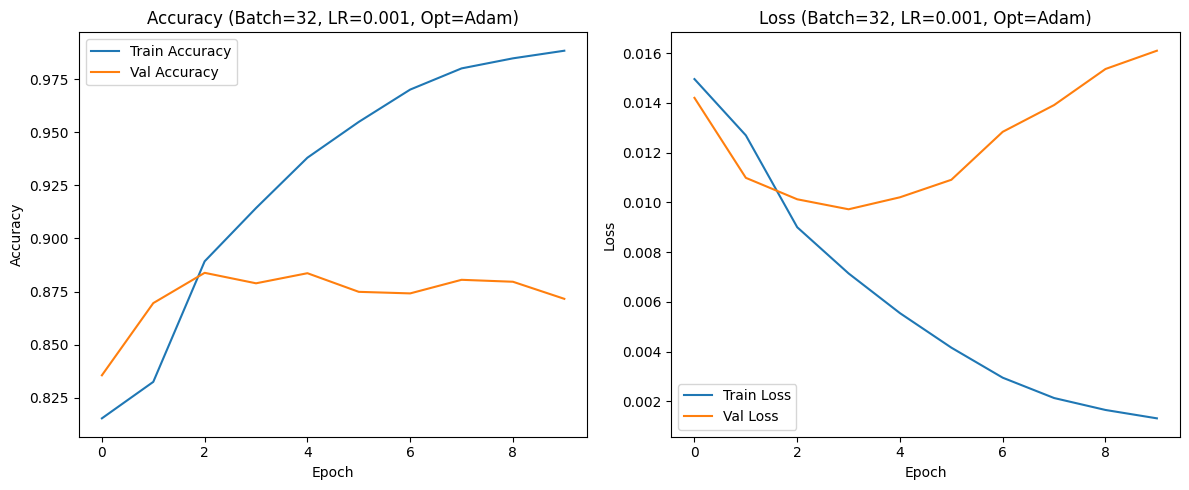

Training LSTM with batch_size=32, lr=0.001, optimizer=SGD
Epoch 1/10 -> Train Loss: 0.0156, Train Acc: 0.8025, Val Loss: 0.0145, Val Acc: 0.8334
Epoch 2/10 -> Train Loss: 0.0152, Train Acc: 0.8136, Val Loss: 0.0144, Val Acc: 0.8351
Epoch 3/10 -> Train Loss: 0.0151, Train Acc: 0.8150, Val Loss: 0.0144, Val Acc: 0.8358
Epoch 4/10 -> Train Loss: 0.0151, Train Acc: 0.8157, Val Loss: 0.0144, Val Acc: 0.8363
Epoch 5/10 -> Train Loss: 0.0151, Train Acc: 0.8158, Val Loss: 0.0143, Val Acc: 0.8363
Epoch 6/10 -> Train Loss: 0.0151, Train Acc: 0.8158, Val Loss: 0.0143, Val Acc: 0.8363
Epoch 7/10 -> Train Loss: 0.0150, Train Acc: 0.8158, Val Loss: 0.0143, Val Acc: 0.8365
Epoch 8/10 -> Train Loss: 0.0150, Train Acc: 0.8158, Val Loss: 0.0142, Val Acc: 0.8365
Epoch 9/10 -> Train Loss: 0.0150, Train Acc: 0.8158, Val Loss: 0.0142, Val Acc: 0.8365
Epoch 10/10 -> Train Loss: 0.0150, Train Acc: 0.8158, Val Loss: 0.0142, Val Acc: 0.8365
Final Results (Batch=32, LR=0.001, Opt=SGD):
Precision: 0.7270, Recall:

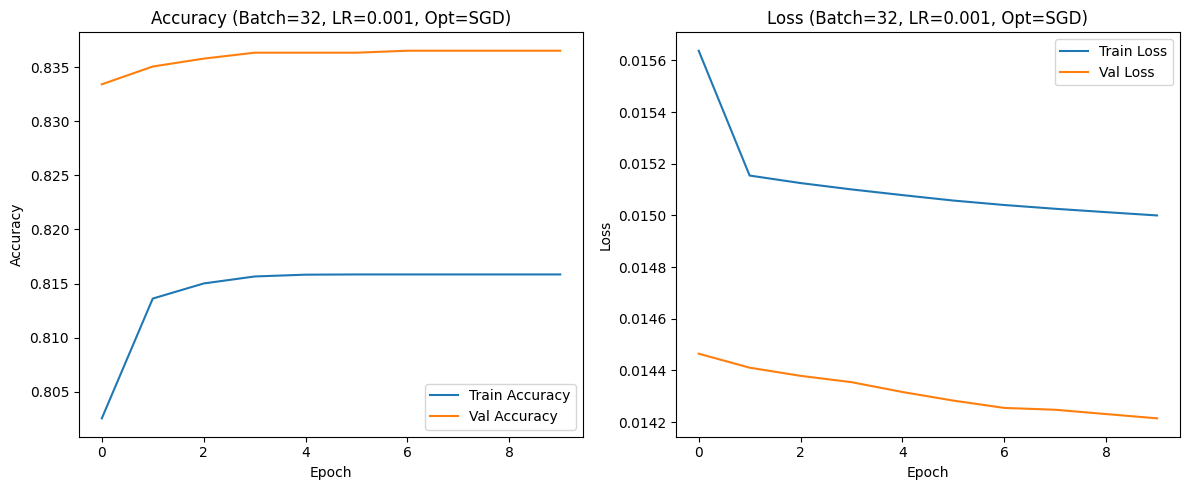

Training LSTM with batch_size=32, lr=0.0001, optimizer=Adam
Epoch 1/10 -> Train Loss: 0.0151, Train Acc: 0.8139, Val Loss: 0.0139, Val Acc: 0.8365
Epoch 2/10 -> Train Loss: 0.0149, Train Acc: 0.8158, Val Loss: 0.0139, Val Acc: 0.8365
Epoch 3/10 -> Train Loss: 0.0148, Train Acc: 0.8164, Val Loss: 0.0139, Val Acc: 0.8356
Epoch 4/10 -> Train Loss: 0.0147, Train Acc: 0.8177, Val Loss: 0.0139, Val Acc: 0.8340
Epoch 5/10 -> Train Loss: 0.0145, Train Acc: 0.8194, Val Loss: 0.0137, Val Acc: 0.8347
Epoch 6/10 -> Train Loss: 0.0145, Train Acc: 0.8205, Val Loss: 0.0136, Val Acc: 0.8349
Epoch 7/10 -> Train Loss: 0.0140, Train Acc: 0.8211, Val Loss: 0.0125, Val Acc: 0.8365
Epoch 8/10 -> Train Loss: 0.0124, Train Acc: 0.8366, Val Loss: 0.0115, Val Acc: 0.8552
Epoch 9/10 -> Train Loss: 0.0115, Train Acc: 0.8500, Val Loss: 0.0121, Val Acc: 0.8382
Epoch 10/10 -> Train Loss: 0.0107, Train Acc: 0.8629, Val Loss: 0.0107, Val Acc: 0.8679
Final Results (Batch=32, LR=0.0001, Opt=Adam):
Precision: 0.8065, Rec

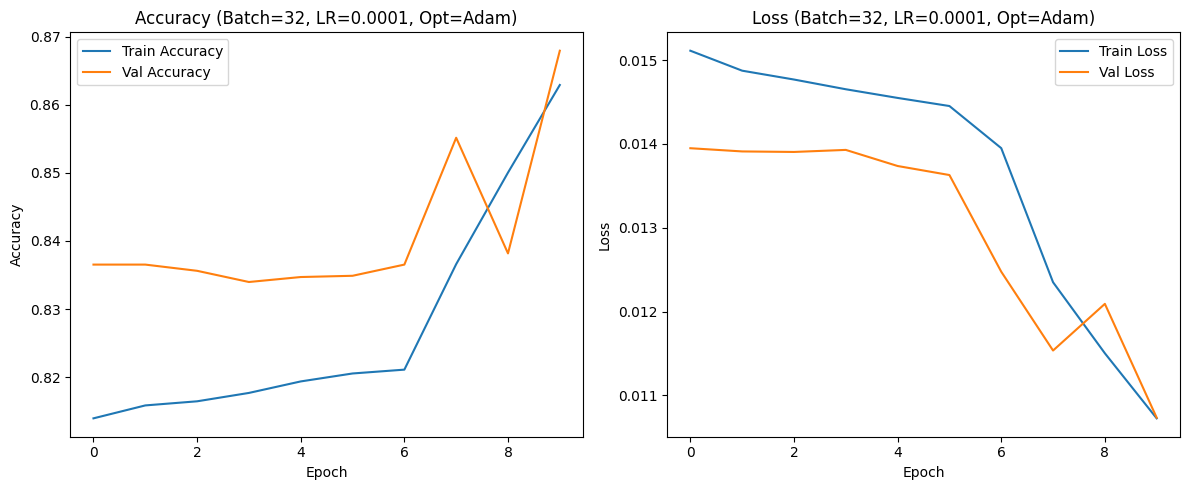

Training LSTM with batch_size=32, lr=0.0001, optimizer=SGD
Epoch 1/10 -> Train Loss: 0.0184, Train Acc: 0.7917, Val Loss: 0.0162, Val Acc: 0.8283
Epoch 2/10 -> Train Loss: 0.0159, Train Acc: 0.8089, Val Loss: 0.0150, Val Acc: 0.8318
Epoch 3/10 -> Train Loss: 0.0154, Train Acc: 0.8109, Val Loss: 0.0147, Val Acc: 0.8321
Epoch 4/10 -> Train Loss: 0.0152, Train Acc: 0.8121, Val Loss: 0.0145, Val Acc: 0.8325
Epoch 5/10 -> Train Loss: 0.0152, Train Acc: 0.8125, Val Loss: 0.0145, Val Acc: 0.8325
Epoch 6/10 -> Train Loss: 0.0152, Train Acc: 0.8131, Val Loss: 0.0145, Val Acc: 0.8327
Epoch 7/10 -> Train Loss: 0.0152, Train Acc: 0.8134, Val Loss: 0.0145, Val Acc: 0.8334
Epoch 8/10 -> Train Loss: 0.0152, Train Acc: 0.8138, Val Loss: 0.0144, Val Acc: 0.8336
Epoch 9/10 -> Train Loss: 0.0152, Train Acc: 0.8140, Val Loss: 0.0144, Val Acc: 0.8340
Epoch 10/10 -> Train Loss: 0.0152, Train Acc: 0.8142, Val Loss: 0.0144, Val Acc: 0.8342
Final Results (Batch=32, LR=0.0001, Opt=SGD):
Precision: 0.7388, Recal

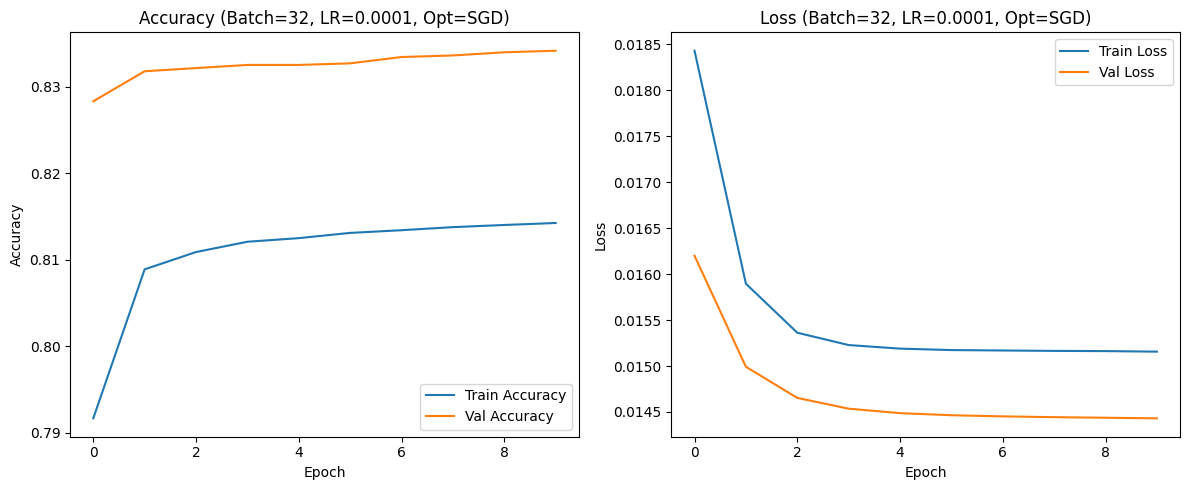

Training LSTM with batch_size=64, lr=0.001, optimizer=Adam
Epoch 1/10 -> Train Loss: 0.0075, Train Acc: 0.8152, Val Loss: 0.0071, Val Acc: 0.8360
Epoch 2/10 -> Train Loss: 0.0071, Train Acc: 0.8189, Val Loss: 0.0059, Val Acc: 0.8584
Epoch 3/10 -> Train Loss: 0.0051, Train Acc: 0.8706, Val Loss: 0.0049, Val Acc: 0.8796
Epoch 4/10 -> Train Loss: 0.0040, Train Acc: 0.9030, Val Loss: 0.0047, Val Acc: 0.8864
Epoch 5/10 -> Train Loss: 0.0033, Train Acc: 0.9210, Val Loss: 0.0049, Val Acc: 0.8853
Epoch 6/10 -> Train Loss: 0.0027, Train Acc: 0.9379, Val Loss: 0.0053, Val Acc: 0.8784
Epoch 7/10 -> Train Loss: 0.0021, Train Acc: 0.9541, Val Loss: 0.0060, Val Acc: 0.8855
Epoch 8/10 -> Train Loss: 0.0016, Train Acc: 0.9673, Val Loss: 0.0064, Val Acc: 0.8700
Epoch 9/10 -> Train Loss: 0.0013, Train Acc: 0.9764, Val Loss: 0.0071, Val Acc: 0.8625
Epoch 10/10 -> Train Loss: 0.0010, Train Acc: 0.9831, Val Loss: 0.0070, Val Acc: 0.8736
Final Results (Batch=64, LR=0.001, Opt=Adam):
Precision: 0.8591, Recal

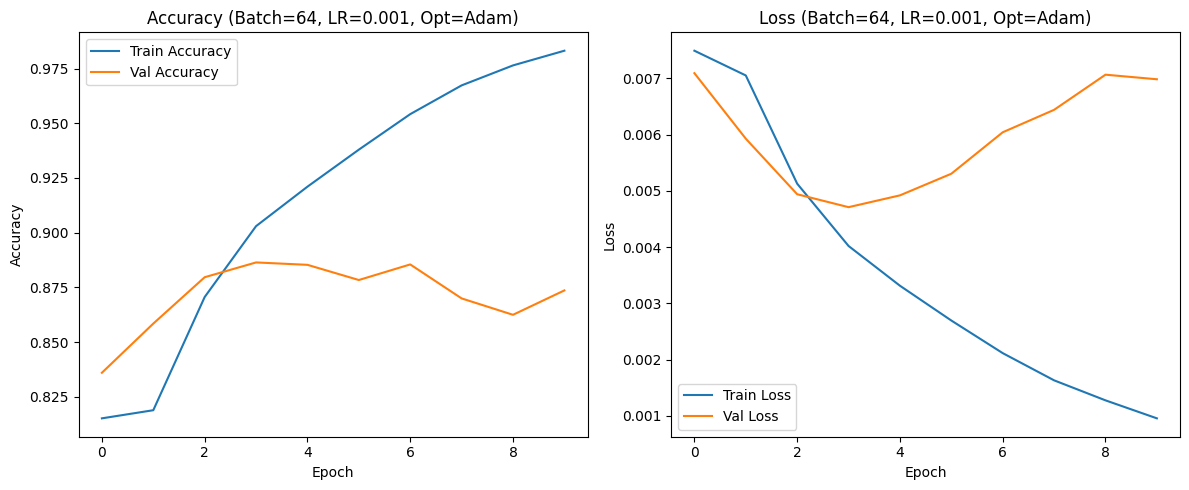

Training LSTM with batch_size=64, lr=0.001, optimizer=SGD
Epoch 1/10 -> Train Loss: 0.0078, Train Acc: 0.8127, Val Loss: 0.0072, Val Acc: 0.8331
Epoch 2/10 -> Train Loss: 0.0076, Train Acc: 0.8144, Val Loss: 0.0072, Val Acc: 0.8340
Epoch 3/10 -> Train Loss: 0.0076, Train Acc: 0.8153, Val Loss: 0.0072, Val Acc: 0.8351
Epoch 4/10 -> Train Loss: 0.0076, Train Acc: 0.8155, Val Loss: 0.0072, Val Acc: 0.8354
Epoch 5/10 -> Train Loss: 0.0076, Train Acc: 0.8157, Val Loss: 0.0072, Val Acc: 0.8358
Epoch 6/10 -> Train Loss: 0.0076, Train Acc: 0.8158, Val Loss: 0.0072, Val Acc: 0.8362
Epoch 7/10 -> Train Loss: 0.0076, Train Acc: 0.8158, Val Loss: 0.0072, Val Acc: 0.8363
Epoch 8/10 -> Train Loss: 0.0075, Train Acc: 0.8158, Val Loss: 0.0072, Val Acc: 0.8365
Epoch 9/10 -> Train Loss: 0.0075, Train Acc: 0.8158, Val Loss: 0.0072, Val Acc: 0.8365
Epoch 10/10 -> Train Loss: 0.0075, Train Acc: 0.8158, Val Loss: 0.0072, Val Acc: 0.8365
Final Results (Batch=64, LR=0.001, Opt=SGD):
Precision: 0.7249, Recall:

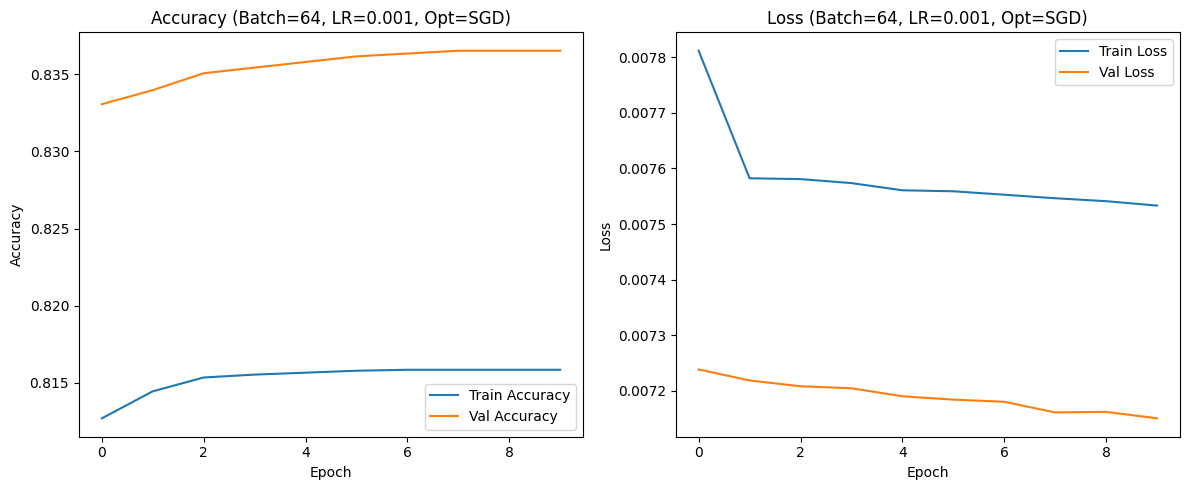

Training LSTM with batch_size=64, lr=0.0001, optimizer=Adam
Epoch 1/10 -> Train Loss: 0.0076, Train Acc: 0.8141, Val Loss: 0.0070, Val Acc: 0.8365
Epoch 2/10 -> Train Loss: 0.0075, Train Acc: 0.8158, Val Loss: 0.0070, Val Acc: 0.8365
Epoch 3/10 -> Train Loss: 0.0074, Train Acc: 0.8159, Val Loss: 0.0069, Val Acc: 0.8365
Epoch 4/10 -> Train Loss: 0.0074, Train Acc: 0.8161, Val Loss: 0.0070, Val Acc: 0.8365
Epoch 5/10 -> Train Loss: 0.0073, Train Acc: 0.8168, Val Loss: 0.0070, Val Acc: 0.8356
Epoch 6/10 -> Train Loss: 0.0073, Train Acc: 0.8175, Val Loss: 0.0070, Val Acc: 0.8349
Epoch 7/10 -> Train Loss: 0.0072, Train Acc: 0.8185, Val Loss: 0.0068, Val Acc: 0.8343
Epoch 8/10 -> Train Loss: 0.0069, Train Acc: 0.8189, Val Loss: 0.0064, Val Acc: 0.8349
Epoch 9/10 -> Train Loss: 0.0062, Train Acc: 0.8314, Val Loss: 0.0060, Val Acc: 0.8435
Epoch 10/10 -> Train Loss: 0.0057, Train Acc: 0.8517, Val Loss: 0.0057, Val Acc: 0.8614
Final Results (Batch=64, LR=0.0001, Opt=Adam):
Precision: 0.8010, Rec

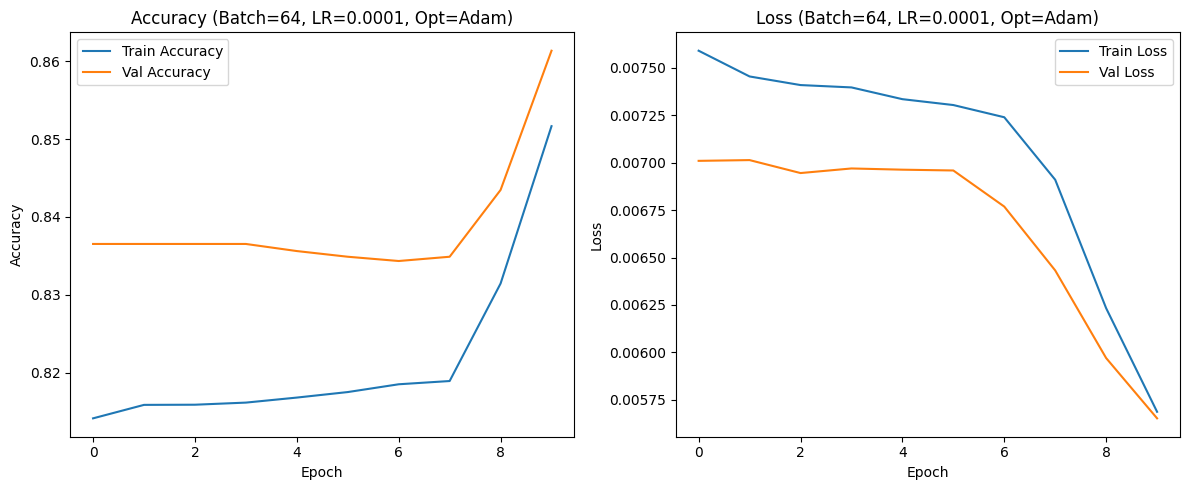

Training LSTM with batch_size=64, lr=0.0001, optimizer=SGD
Epoch 1/10 -> Train Loss: 0.0104, Train Acc: 0.6273, Val Loss: 0.0093, Val Acc: 0.8228
Epoch 2/10 -> Train Loss: 0.0088, Train Acc: 0.8074, Val Loss: 0.0082, Val Acc: 0.8274
Epoch 3/10 -> Train Loss: 0.0081, Train Acc: 0.8100, Val Loss: 0.0077, Val Acc: 0.8278
Epoch 4/10 -> Train Loss: 0.0079, Train Acc: 0.8113, Val Loss: 0.0075, Val Acc: 0.8294
Epoch 5/10 -> Train Loss: 0.0077, Train Acc: 0.8119, Val Loss: 0.0074, Val Acc: 0.8301
Epoch 6/10 -> Train Loss: 0.0077, Train Acc: 0.8121, Val Loss: 0.0073, Val Acc: 0.8305
Epoch 7/10 -> Train Loss: 0.0076, Train Acc: 0.8124, Val Loss: 0.0073, Val Acc: 0.8307
Epoch 8/10 -> Train Loss: 0.0076, Train Acc: 0.8126, Val Loss: 0.0073, Val Acc: 0.8309
Epoch 9/10 -> Train Loss: 0.0076, Train Acc: 0.8128, Val Loss: 0.0073, Val Acc: 0.8312
Epoch 10/10 -> Train Loss: 0.0076, Train Acc: 0.8129, Val Loss: 0.0073, Val Acc: 0.8314
Final Results (Batch=64, LR=0.0001, Opt=SGD):
Precision: 0.7091, Recal

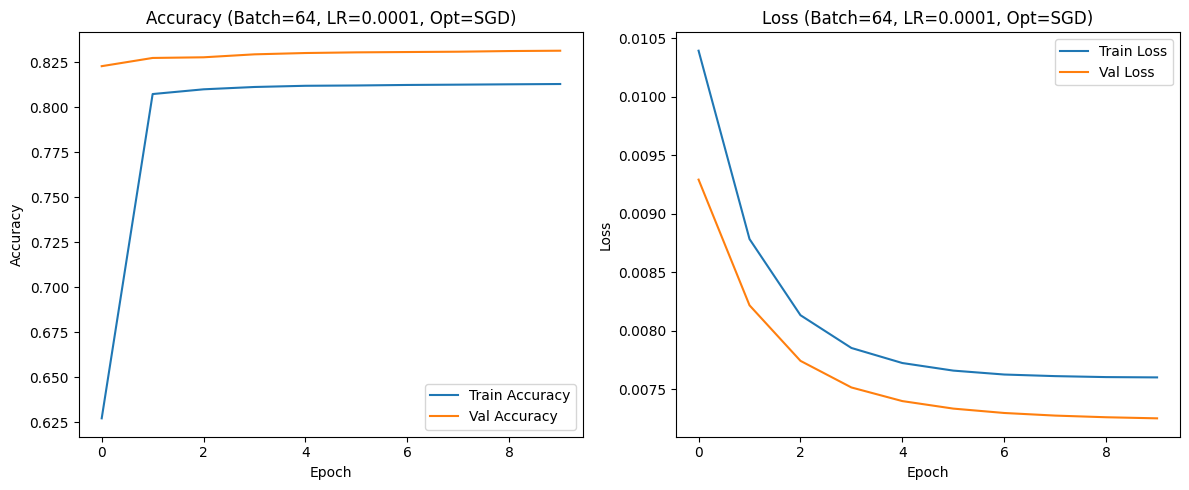

In [ ]:
vocab_size = len(vocab)

for batch_size, learning_rate, optimizer_name in itertools.product(batch_sizes, learning_rates, optimizers):
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

    model = LSTMModel(vocab_size).to(device)
    criterion = nn.CrossEntropyLoss()

    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    if optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    print(f"Training LSTM with batch_size={batch_size}, lr={learning_rate}, optimizer={optimizer_name}")

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    all_true_labels, all_predicted_labels = [], []

    for epoch in range(10):
        train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc, true_labels, predicted_labels = evaluate(model, val_loader, criterion, device)


        all_true_labels.extend(true_labels)
        all_predicted_labels.extend(predicted_labels)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1}/10 -> Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Tính Precision, Recall, F1-Score sau khi hoàn tất các epoch
    precision = precision_score(all_true_labels, all_predicted_labels, average="weighted")
    recall = recall_score(all_true_labels, all_predicted_labels, average="weighted")
    f1 = f1_score(all_true_labels, all_predicted_labels, average="weighted")

    print(f"Final Results (Batch={batch_size}, LR={learning_rate}, Opt={optimizer_name}):")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

    # Store results
    results.append((batch_size, learning_rate, optimizer_name, max(val_accs)))

    # Plot accuracy and loss for each combination
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_accs, label="Train Accuracy")
    plt.plot(val_accs, label="Val Accuracy")
    plt.title(f"Accuracy (Batch={batch_size}, LR={learning_rate}, Opt={optimizer_name})")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.title(f"Loss (Batch={batch_size}, LR={learning_rate}, Opt={optimizer_name})")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()


# Chọn batch_size=64, lr=0.001, optimizer=Adam


In [19]:
batch_sizes = [64]
learning_rates = [1e-3]
optimizers = ['Adam']
results = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Training LSTM with batch_size=64, lr=0.001, optimizer=Adam
Epoch 1/10 -> Train Loss: 0.0075, Train Acc: 0.8143, Test Loss: 0.0063, Test Acc: 0.8646
Epoch 2/10 -> Train Loss: 0.0073, Train Acc: 0.8170, Test Loss: 0.0060, Test Acc: 0.8630
Epoch 3/10 -> Train Loss: 0.0059, Train Acc: 0.8440, Test Loss: 0.0046, Test Acc: 0.8881
Epoch 4/10 -> Train Loss: 0.0044, Train Acc: 0.8906, Test Loss: 0.0040, Test Acc: 0.9076
Epoch 5/10 -> Train Loss: 0.0037, Train Acc: 0.9133, Test Loss: 0.0037, Test Acc: 0.9120
Epoch 6/10 -> Train Loss: 0.0031, Train Acc: 0.9311, Test Loss: 0.0038, Test Acc: 0.9110
Epoch 7/10 -> Train Loss: 0.0025, Train Acc: 0.9472, Test Loss: 0.0037, Test Acc: 0.9219
Epoch 8/10 -> Train Loss: 0.0020, Train Acc: 0.9605, Test Loss: 0.0040, Test Acc: 0.9172
Epoch 9/10 -> Train Loss: 0.0016, Train Acc: 0.9708, Test Loss: 0.0042, Test Acc: 0.9175
Epoch 10/10 -> Train Loss: 0.0013, Train Acc: 0.9785, Test Loss: 0.0044, Test Acc: 0.9211
Final Results (Batch=64, LR=0.001, Opt=Adam):
Prec

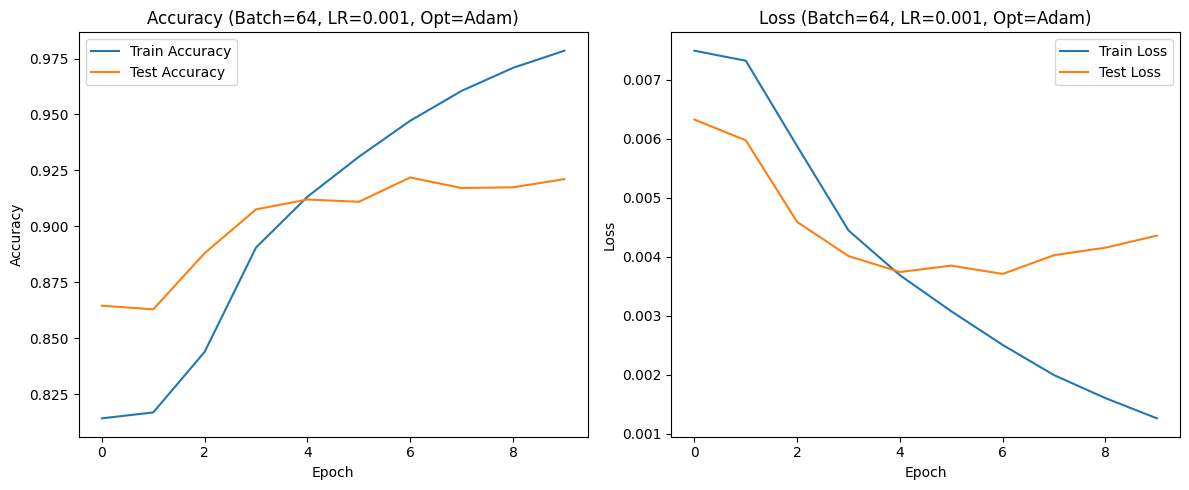

In [20]:
for batch_size, learning_rate, optimizer_name in itertools.product(batch_sizes, learning_rates, optimizers):
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

        model = LSTMModel(vocab_size).to(device)
        criterion = nn.CrossEntropyLoss()

        if optimizer_name == 'Adam':
            optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        print(f"Training LSTM with batch_size={batch_size}, lr={learning_rate}, optimizer={optimizer_name}")

        train_losses, test_losses = [], []
        train_accs, test_accs = [], []
        all_true_labels, all_predicted_labels = [], []

        for epoch in range(10):
            train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
            test_loss, test_acc, true_labels, predicted_labels = evaluate(model, test_loader, criterion, device)

            all_true_labels.extend(true_labels)
            all_predicted_labels.extend(predicted_labels)

            train_losses.append(train_loss)
            test_losses.append(test_loss)
            train_accs.append(train_acc)
            test_accs.append(test_acc)

            print(f"Epoch {epoch+1}/10 -> Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

        precision = precision_score(all_true_labels, all_predicted_labels, average="weighted")
        recall = recall_score(all_true_labels, all_predicted_labels, average="weighted")
        f1 = f1_score(all_true_labels, all_predicted_labels, average="weighted")

        print(f"Final Results (Batch={batch_size}, LR={learning_rate}, Opt={optimizer_name}):")
        print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

        torch.save(model.state_dict(), "LSTMmodel.pth")
        # Store results
        results.append((batch_size, learning_rate, optimizer_name, max(test_accs)))

        # Plot accuracy and loss for each combination
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(train_accs, label="Train Accuracy")
        plt.plot(test_accs, label="Test Accuracy")
        plt.title(f"Accuracy (Batch={batch_size}, LR={learning_rate}, Opt={optimizer_name})")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(train_losses, label="Train Loss")
        plt.plot(test_losses, label="Test Loss")
        plt.title(f"Loss (Batch={batch_size}, LR={learning_rate}, Opt={optimizer_name})")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()

        plt.tight_layout()
        plt.show()

